In [2]:
from jenga.tasks.income import IncomeEstimationTask
from jenga.corruptions.generic import MissingValues
from jenga.evaluation.corruption_impact import CorruptionImpactEvaluator
import matplotlib.pyplot as plt

import numpy as np
import datawig 

In [3]:
task = IncomeEstimationTask(seed=42)

In [4]:
class ModeImputer:
    def __init__(self, columns):
        self.columns = columns
        self.modes = {}
        
    def fit(self, data):
        for column in self.columns:
            mode = data[column].value_counts().index[0]
            self.modes[column] = mode
            
    def transform(self, data):
        imputed = data.copy(deep=True)
        for column in self.columns:
            imputed[column].fillna(self.modes[column], inplace=True) 
        return imputed
            
imputer = ModeImputer(['education', 'workclass', 'marital_status', 'occupation'])
imputer.fit(task.train_data)

In [5]:
class DatawigImputer:
    def __init__(self, input_columns, target_column):
        self.input_columns = input_columns
        self.target_column = target_column
        self.model = None
        
    def fit(self, data):
        self.model = datawig.SimpleImputer(
            input_columns=self.input_columns,
            output_column=self.target_column,
            output_path = f'imputer_model_{self.target_column}',
            is_explainable=False)

        #self.model.fit(train_df=data, calibrate=False, batch_size=128)
        self.model = self.model.load(f'imputer_model_{self.target_column}')
            
    def transform(self, data):
        imputed = data
        #imputed = data.copy(deep=True)
        imputed = self.model.predict(imputed, inplace=True)
        imputed.loc[imputed[self.target_column].isnull(), self.target_column] = \
            imputed[self.target_column + '_imputed']
        
        return imputed

In [6]:
education_imputer = DatawigImputer(['occupation', 'marital_status', 'workclass'], 'education')
education_imputer.fit(task.train_data)

In [7]:
occupation_imputer = DatawigImputer(['education', 'marital_status', 'workclass'], 'occupation')
occupation_imputer.fit(task.train_data)

In [8]:
marital_status_imputer = DatawigImputer(['education', 'occupation', 'workclass'], 'marital_status')
marital_status_imputer.fit(task.train_data)

In [9]:
workclass_imputer = DatawigImputer(['education', 'occupation', 'marital_status'], 'workclass')
workclass_imputer.fit(task.train_data)

In [10]:
class ChainedModelDecorator:
    def __init__(self, model, imputers):
        self.model = model
        self.imputers = imputers
        
    def predict_proba(self, data):
        #imputed = data.copy(deep=True)
        imputed = data
        for imputer in self.imputers:
            imputed = imputer.transform(imputed)
        
        return self.model.predict_proba(imputed)

In [11]:
class ModelDecorator:
    def __init__(self, model, imputer):
        self.model = model
        self.imputer = imputer
        
    def predict_proba(self, data):
        return self.model.predict_proba(self.imputer.transform(data))

In [12]:
evaluator = CorruptionImpactEvaluator(task)

corruptions = []
for impacted_column in ['education', 'workclass', 'marital_status', 'occupation']:
    for fraction in [0.99, 0.5, 0.25, 0.1, 0.01]:
        for missingness in ['MCAR', 'MAR', 'MNAR']:
            corruption = MissingValues(impacted_column, fraction, missingness=missingness, na_value=np.nan)
            corruptions.append(corruption)

In [13]:
model = task.fit_baseline_model(task.train_data, task.train_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.9s finished


In [14]:
chained_decorated_model = ChainedModelDecorator(model, [education_imputer, workclass_imputer, 
                                                        marital_status_imputer, occupation_imputer])

In [15]:
decorated_model = ModelDecorator(model, imputer)

In [25]:
results = evaluator.evaluate(model, 50, *corruptions)
decorated_results = evaluator.evaluate(decorated_model, 50, *corruptions)

10/3000 (0.13703277200147568)
20/3000 (0.2854353330003505)
30/3000 (0.4422911390010995)
40/3000 (0.56681671700062)
50/3000 (0.7086648520016752)
60/3000 (0.8594099830006598)
70/3000 (1.0180116090014053)
80/3000 (1.1741291520011146)
90/3000 (1.3331390930015914)
100/3000 (1.4874504850013182)
110/3000 (1.6515311950006435)
120/3000 (1.813360146001287)
130/3000 (1.9941166900007374)
140/3000 (2.156925579000017)
150/3000 (2.3336978220013407)
160/3000 (2.458023963999949)
170/3000 (2.588983661000384)
180/3000 (2.712385497001378)
190/3000 (2.845442877000096)
200/3000 (2.9698133770016284)
210/3000 (3.1291751620010473)
220/3000 (3.290856994000933)
230/3000 (3.447361982000075)
240/3000 (3.592800938000437)
250/3000 (3.7506160990014905)
260/3000 (3.9154492280013073)
270/3000 (4.081828533000589)
280/3000 (4.24464843900023)
290/3000 (4.416336459000377)
300/3000 (4.584021070000745)
310/3000 (4.718505214001198)
320/3000 (4.849994566000532)
330/3000 (4.9989704660001735)
340/3000 (5.138435787001072)
350/300

2760/3000 (44.897743988)
2770/3000 (45.06678865499998)
2780/3000 (45.26851104600064)
2790/3000 (45.44615315900046)
2800/3000 (45.61906719700164)
2810/3000 (45.7966268650016)
2820/3000 (45.9741139100006)
2830/3000 (46.15244833900033)
2840/3000 (46.33295045700106)
2850/3000 (46.515803168000275)
2860/3000 (46.66345775300033)
2870/3000 (46.83108492300016)
2880/3000 (46.98385377500017)
2890/3000 (47.13763739600108)
2900/3000 (47.28849753900067)
2910/3000 (47.465251496001656)
2920/3000 (47.66214761400079)
2930/3000 (47.85915985500105)
2940/3000 (48.02859289600019)
2950/3000 (48.195260418000544)
2960/3000 (48.37527983400105)
2970/3000 (48.559152623000045)
2980/3000 (48.74759216500024)
2990/3000 (48.95801787900018)
3000/3000 (49.14586503600003)
10/3000 (0.16724041499946907)
20/3000 (0.33397204100037925)
30/3000 (0.4973087170001236)
40/3000 (0.6614758870000514)
50/3000 (0.8274016560008022)
60/3000 (1.0323525780004275)
70/3000 (1.2326060800005507)
80/3000 (1.436923678000312)
90/3000 (1.647584292

2500/3000 (47.99442611499944)
2510/3000 (48.20448083200063)
2520/3000 (48.41661941299935)
2530/3000 (48.62574449599924)
2540/3000 (48.834841603000314)
2550/3000 (49.04402461000063)
2560/3000 (49.2066830370004)
2570/3000 (49.37211445399953)
2580/3000 (49.534777815999405)
2590/3000 (49.698539443999834)
2600/3000 (49.86236651800027)
2610/3000 (50.06099310399986)
2620/3000 (50.25172426499921)
2630/3000 (50.45005017100084)
2640/3000 (50.64556533900031)
2650/3000 (50.84409236099964)
2660/3000 (51.04843685299966)
2670/3000 (51.25662293999994)
2680/3000 (51.46305236099943)
2690/3000 (51.6693851050004)
2700/3000 (51.874998393999704)
2710/3000 (52.037765360000776)
2720/3000 (52.20024487000046)
2730/3000 (52.364352283999324)
2740/3000 (52.527521705000254)
2750/3000 (52.688377664000654)
2760/3000 (52.88342739899963)
2770/3000 (53.08867636700052)
2780/3000 (53.28143023899975)
2790/3000 (53.469182713999544)
2800/3000 (53.66083441000046)
2810/3000 (53.86753568899985)
2820/3000 (54.07122362299924)
283

In [17]:
datawig_results = evaluator.evaluate(chained_decorated_model, 5, *corruptions)

/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

10/300 (286.617688001)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

20/300 (592.509542005)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

30/300 (918.2258159830001)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

40/300 (1228.6256264)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

50/300 (1547.5556710580001)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

60/300 (1852.9421325619999)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

70/300 (2159.497855222)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

80/300 (2467.570139051)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

90/300 (2797.4333593369997)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

100/300 (3121.496156537)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

110/300 (3462.200560331)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

120/300 (3806.557136139)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

130/300 (4123.888789345)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

140/300 (4426.252275749001)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

150/300 (4727.269947933)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

160/300 (5043.138598175)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

170/300 (5375.9511846430005)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

180/300 (5720.752891381)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

190/300 (6057.147897517)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

200/300 (6363.353238132)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

210/300 (6694.366333325001)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

220/300 (6999.942456232)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

230/300 (7304.211094159)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

240/300 (7592.7130034580005)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

250/300 (7941.411503069001)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

260/300 (8306.880490943)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

270/300 (8606.585600067001)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

280/300 (8891.127158821)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

290/300 (9190.773865739)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during f

300/300 (9537.31482842)


/home/ssc/Entwicklung/projects/jenga/env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [18]:
def find_result(column, fraction, missingness, results):
    for result in results:
        corr = result.corruption
        if corr.column == column and corr.fraction == fraction and corr.missingness == missingness:
            return result

In [19]:
def plot_impact(column, plt, results, suffix=''):
    ax = plt.gca()
    
    scores = []
    labels = []

    for impacted_column in [column]:
        for fraction in [0.01, 0.1, 0.5, 0.99]:
            for missingness in ['MCAR', 'MAR', 'MNAR']:        
                result = find_result(impacted_column, fraction, missingness, results)
                scores.append(result.corrupted_scores)
                labels.append(f"{missingness} {int(fraction*100)}%")

    baseline_score = result.baseline_score            

    ax.axhline(baseline_score, linestyle='--', color='red')
    bplot = ax.boxplot(scores, showfliers=False, patch_artist=True, medianprops={'color':'black'})

    colors = ['#1e4052', '#dc6082', '#e1a677',
              '#1e4052', '#dc6082', '#e1a677', 
              '#1e4052', '#dc6082', '#e1a677', 
              '#1e4052', '#dc6082', '#e1a677']
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
    ax.yaxis.grid(True)

    ax.set_xticklabels(labels)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.set_ylim((0.79, 0.895))
    ax.set_title(f"Missing values in '{column}'", fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)    
    ax.set_ylabel('AUC', fontsize=24)
    
    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()
    plt.gcf().savefig(f'/home/ssc/nextcloud/papers/jenga/figures/missing-{column}{suffix}.pdf', dpi=300)
    plt.show()

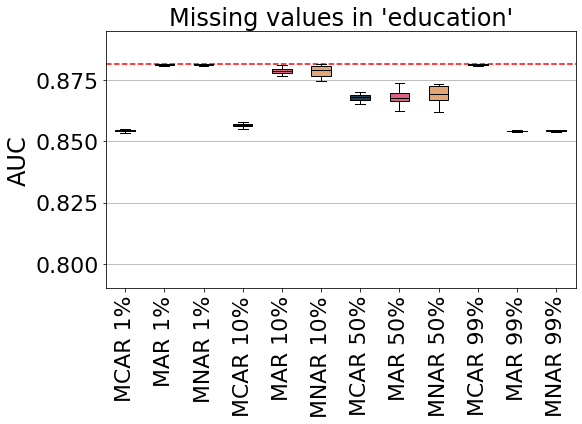

In [26]:
plot_impact('education', plt, results)

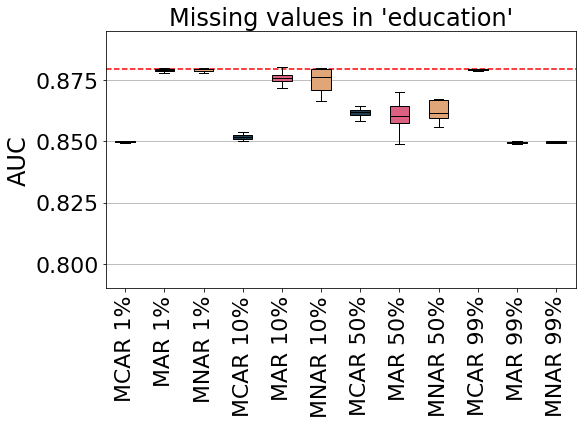

In [27]:
plot_impact('education', plt, decorated_results, '-mode')

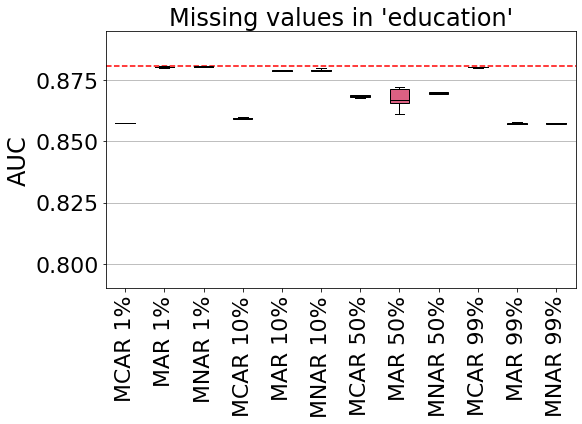

In [21]:
plot_impact('education', plt, datawig_results, '-datawig')

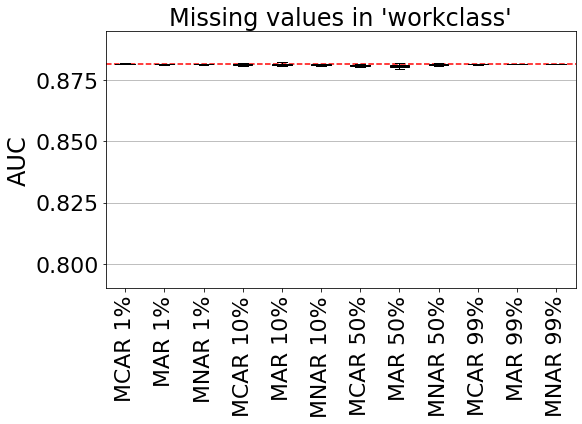

In [28]:
plot_impact('workclass', plt, results)

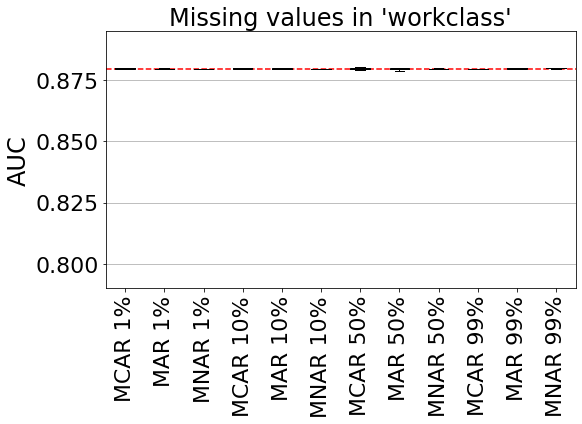

In [29]:
plot_impact('workclass', plt, decorated_results, '-mode')

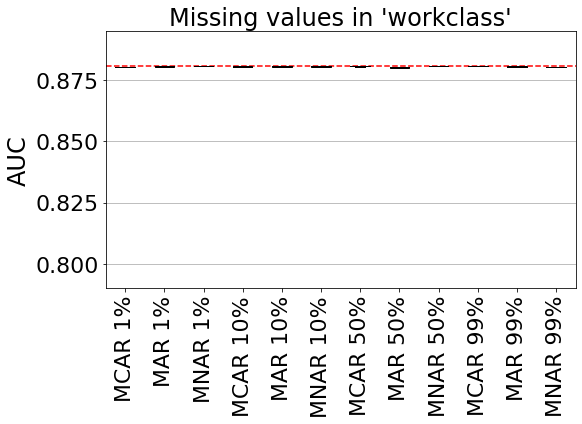

In [30]:
plot_impact('workclass', plt, datawig_results, '-datawig')

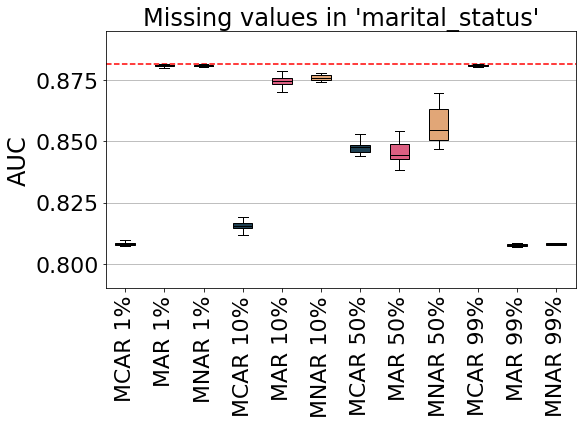

In [31]:
plot_impact('marital_status', plt, results)

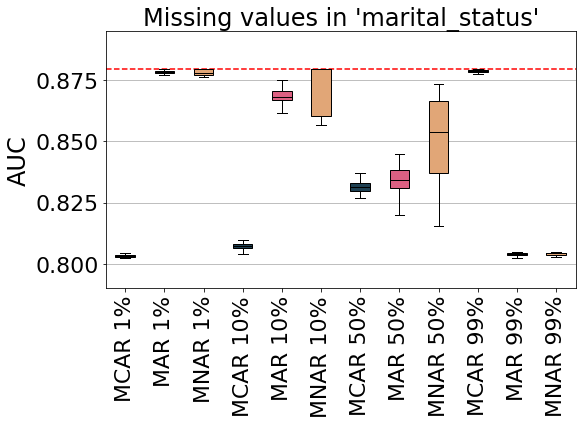

In [32]:
plot_impact('marital_status', plt, decorated_results, '-mode')

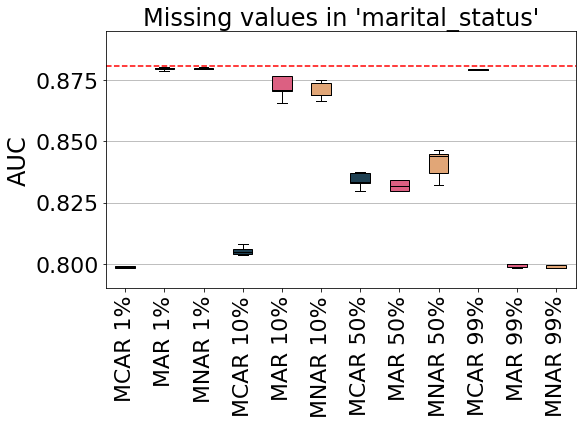

In [23]:
plot_impact('marital_status', plt, datawig_results, '-datawig')

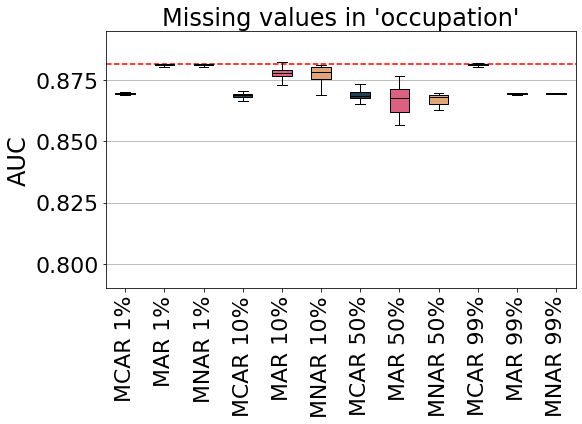

In [33]:
plot_impact('occupation', plt, results)

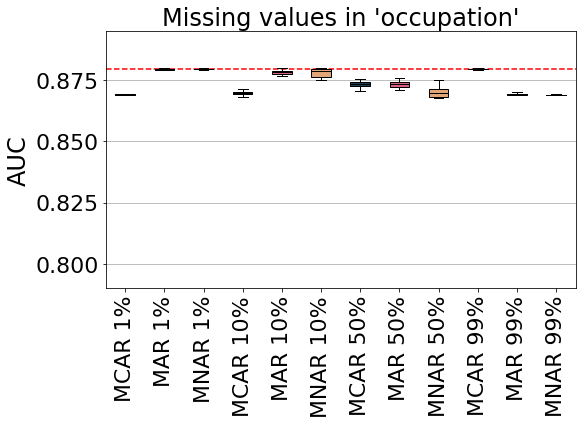

In [34]:
plot_impact('occupation', plt, decorated_results, '-mode')

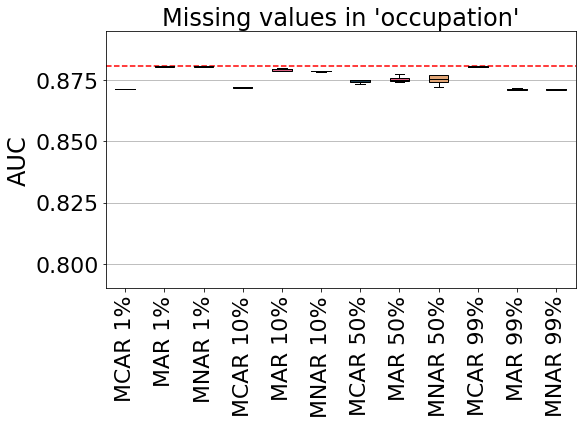

In [35]:
plot_impact('occupation', plt, datawig_results, '-datawig')

In [51]:
import jsonpickle


with open("datawig-results.jsonpickle", "w") as text_file:
    text_file.write(jsonpickle.encode(datawig_results))
    
with open("mode-results.jsonpickle", "w") as text_file:
    text_file.write(jsonpickle.encode(decorated_results))    
    
with open("no-results.jsonpickle", "w") as text_file:
    text_file.write(jsonpickle.encode(results))        